In [1]:
import gym
import numpy as np
import os
from offsim4rl.data import OfflineDataset, ProbDistribution
from offsim4rl.evaluators.per_state_rejection import PerStateRejectionSampling
from offsim4rl.agents import spinup
import torch

/anaconda/envs/offsim4rl2/lib/python3.7/site-packages/tensorflow_core/python/pywrap_tensorflow_internal.py:15: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
/anaconda/envs/offsim4rl2/lib/python3.7/site-packages/keras_preprocessing/image/utils.py:23: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  'nearest': pil_image.NEAREST,
/anaconda/envs/offsim4rl2/lib/python3.7/site-packages/keras_preprocessing/image/utils.py:24: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  'bilinear': pil_image.BILINEAR,
/anaconda/envs/offsim4rl2/lib/python3.7/site-packages/keras_preprocessing/image/utils.py:25: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  'bicubic': pil_image.BIC

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

/anaconda/envs/offsim4rl2/lib/python3.7/site-packages/matplotlib/__init__.py:200: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
/anaconda/envs/offsim4rl2/lib/python3.7/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


In [3]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
from offsim4rl.utils.dataset_utils import load_h5_dataset
buffer = load_h5_dataset('./outputs/CartPole-v1_ppo.h5')

load datafile: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 194.81it/s]


In [5]:
import argparse
parser = argparse.ArgumentParser()
args = parser.parse_args([])
args.seed = 0
args.latent_size = 16
args.hidden_size = 64
args.lr = 0.001
args.weight_decay = 0.0

category = 'both'
trial = '20220823T0310'
args.output_dir = "./outputs/models/" + f"./trial={trial},encoder_model={category},seed={args.seed}," + \
        f"dZ={args.latent_size},dH={args.hidden_size},lr={args.lr},weight_decay={args.weight_decay}/"

In [6]:
from offsim4rl.encoders.homer import HOMEREncoder
class HOMEREncoder_CartPole(HOMEREncoder):
    def _visualize(self, fname='latent_state.png'):
        obs = torch.tensor(buffer['observations'], dtype=torch.float, device=device)
        emb = self.encode(obs)
        df_output = pd.DataFrame([(i, *x) for i, x in zip(emb, obs)], columns=['i', 'x', "x'", 'y', "y'"])
        fig, ax = plt.subplots(figsize=(4, 4))
        plt.scatter(df_output['x'], df_output['y'], c=df_output['i'], cmap='nipy_spectral', marker='.', lw=0, s=3)
        plt.xlim(-2.5, 2.5)
        plt.ylim(-0.25, 0.25)
        plt.axhline(-0.2095, c='gray')
        plt.axhline(0.2095, c='gray')
        plt.axvline(-2.4, c='gray')
        plt.axvline(2.4, c='gray')
        plt.xlabel('Cart Position')
        plt.ylabel('Pole Angle')
        plt.savefig(os.path.join(args.output_dir, model_dir, 'vis', fname))

homer_encoder = HOMEREncoder_CartPole(
    obs_dim=4, action_dim=2,
    latent_size=args.latent_size,
    hidden_size=args.hidden_size,
    model_path=os.path.join(args.output_dir, 'models', 'encoder_model.pt'),
    log_dir=os.path.join(args.output_dir, 'logs'),
)

/anaconda/envs/offsim4rl2/lib/python3.7/site-packages/azureml/data/dataset_type_definitions.py:69: DeprecationWarning: FileType Enum is Deprecated in > 1.0.39. Use strings instead.
  category=DeprecationWarning)


/home/t-stang/microsoft/rl-offline-simulation/offsim4rl/encoders/homer.py:163: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  observations = torch.tensor(observations, dtype=torch.float, device=self.device)
/anaconda/envs/offsim4rl2/lib/python3.7/site-packages/tensorflow_core/contrib/learn/python/learn/learn_io/generator_io.py:26: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Container


NameError: name 'model_dir' is not defined

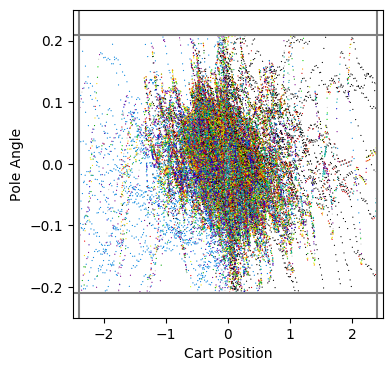

In [7]:
homer_encoder._visualize('tmp.png')

In [8]:
# true env for online validation
env = gym.make('CartPole-v1')
env.seed(100000)

/anaconda/envs/offsim4rl2/lib/python3.7/site-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/anaconda/envs/offsim4rl2/lib/python3.7/site-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/anaconda/en

[100000]

In [9]:
dataset = OfflineDataset(
    observation_space=env.observation_space,
    action_space=env.action_space,
    action_dist_type=ProbDistribution.Discrete,
    observations=buffer['observations'],
    actions=buffer['actions'].astype(int),
    action_distributions=buffer['infos/action_probs'],
    rewards=buffer['rewards'],
    next_observations=buffer['next_observations'],
    terminals=buffer['terminals'].astype(bool),
    steps=buffer['infos/steps'].astype(int),
)

2022-08-23 16:05:45,625 - WARNING - root -  Missing episode_ids in experience. Some algorithms may not be compatible with this dataset.


In [10]:
psrs = PerStateRejectionSampling(
    dataset,
    num_states=50,
    encoder=homer_encoder,
)

In [11]:
for seed in range(10):
    psrs.reset_sampler(seed=seed)
    spinup.ppo_revealed(
        env_fn=lambda: psrs, steps_per_epoch=1000, epochs=100, seed=seed+100, 
        logger_kwargs=dict(output_dir=f'./outputs/cartpole_psrs_homer16/seed={seed}', exp_name='CartPole-v1_ppo'), 
        ac_kwargs=dict(hidden_sizes=[32, 32], activation=torch.nn.ReLU), 
        validate=True, val_kwargs=dict(val_env_fn=lambda: env, val_n_episodes=10))

Logging data to ./outputs/cartpole_psrs_homer16/seed=0/progress.txt
Saving config:

{
    "ac_kwargs":	{
        "activation":	"ReLU",
        "hidden_sizes":	[
            32,
            32
        ]
    },
    "actor_critic":	"MLPActorCritic_Revealed",
    "clip_ratio":	0.2,
    "env_fn":	"<function <lambda> at 0x7fa139e90320>",
    "epochs":	100,
    "exp_name":	"CartPole-v1_ppo",
    "gamma":	0.99,
    "lam":	0.97,
    "logger":	{
        "<spinup.utils.logx.EpochLogger object at 0x7fa0c00dfdd0>":	{
            "epoch_dict":	{},
            "exp_name":	"CartPole-v1_ppo",
            "first_row":	true,
            "log_current_row":	{},
            "log_headers":	[],
            "output_dir":	"./outputs/cartpole_psrs_homer16/seed=0",
            "output_file":	{
                "<_io.TextIOWrapper name='./outputs/cartpole_psrs_homer16/seed=0/progress.txt' mode='w' encoding='UTF-8'>":	{
                    "mode":	"w"
                }
            }
        }
    },
    "logger_kwar

In [12]:
dfs = [pd.read_csv(f'./outputs/cartpole_psrs_homer16/seed={seed}/progress.txt', sep='\t') for seed in range(10)]

In [13]:
df = pd.read_csv('./outputs/cartpole_psrs_homer16/seed=0/progress.txt', sep='\t')

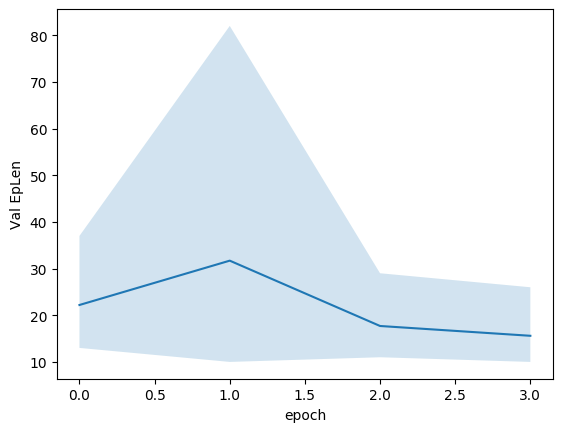

[GCRAZGDL2222:1039935] tcp_peer_recv_connect_ack: invalid header type: 60
[GCRAZGDL2222:1039935] tcp_peer_recv_connect_ack: invalid header type: 15
[GCRAZGDL2222:1039935] tcp_peer_recv_connect_ack: invalid header type: 21
[GCRAZGDL2222:1039935] tcp_peer_recv_connect_ack: invalid header type: 168
[GCRAZGDL2222:1039935] tcp_peer_recv_connect_ack: invalid header type: 81
[GCRAZGDL2222:1039935] tcp_peer_recv_connect_ack: invalid header type: 75
[GCRAZGDL2222:1039935] tcp_peer_recv_connect_ack: invalid header type: 7
[GCRAZGDL2222:1039935] tcp_peer_recv_connect_ack: invalid header type: 26
[GCRAZGDL2222:1039935] tcp_peer_recv_connect_ack: invalid header type: 73
[GCRAZGDL2222:1039935] tcp_peer_recv_connect_ack: invalid header type: 123
[GCRAZGDL2222:1039935] tcp_peer_recv_connect_ack: invalid header type: 86
[GCRAZGDL2222:1039935] tcp_peer_recv_connect_ack: invalid header type: 221
Bad pipe message: %s [b"\x1eVa\x90\x8aQ\x06\xc1\x9c<\x7f\x19\xd6\xea\x04\x80\x033\x00\x00|\xc0,\xc00\x00\xa3\x

In [14]:
plt.plot(df['AverageVal_EpLen'])
plt.fill_between(df['Epoch'], df['MinVal_EpLen'], df['MaxVal_EpLen'], alpha=0.2)
plt.xlabel('epoch')
plt.ylabel('Val EpLen')
plt.show()

In [ ]:
dfs_ = [pd.read_csv(f'./outputs/cartpole_true/seed={seed}/progress.txt', sep='\t') for seed in range(10)]
df_ = pd.concat(dfs_).groupby('Epoch').mean().reset_index()

In [ ]:
plt.plot(df_['AverageVal_EpLen'], color='k', ls='--', label='true', zorder=10)
plt.fill_between(df_['Epoch'], df_['MinVal_EpLen'], df_['MaxVal_EpLen'], alpha=0.2, color='k')
for df in dfs:
    plt.plot(df['AverageVal_EpLen'], lw=1.5, alpha=0.8, label='PSRS HOMER16')
plt.xlabel('epoch')
plt.ylabel('Val EpLen')
plt.legend()
plt.show()

In [ ]:
from spinup.utils.test_policy import load_policy_and_env, run_policy
_, get_action = load_policy_and_env(f'./outputs/cartpole_psrs_homer16/seed={1}')
run_policy(env, lambda x: int(get_action(x).sample()), render=False, num_episodes=10)